In [1]:
!lscpu

Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             52 bits physical, 57 bits virtual
  Byte Order:                Little Endian
CPU(s):                      192
  On-line CPU(s) list:       0-191
Vendor ID:                   AuthenticAMD
  Model name:                AMD EPYC 9684X 96-Core Processor
    CPU family:              25
    Model:                   17
    Thread(s) per core:      1
    Core(s) per socket:      96
    Socket(s):               2
    Stepping:                2
    Frequency boost:         enabled
    CPU(s) scaling MHz:      45%
    CPU max MHz:             3715.4290
    CPU min MHz:             1500.0000
    BogoMIPS:                5100.14
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ht s
                             yscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constan
                         

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from scipy.optimize import fmin, minimize, LinearConstraint, Bounds

from efficient_fpt.multi_stage_cy import (
    compute_loss_parallel,
    print_num_threads,
    compute_tadaloss_parallel,
)

import sys, os

In [3]:
combined_pkl = "addm_data_all_eta_20260206-174356.pkl"  # <-- adjust filename as needed

with open(combined_pkl, "rb") as f:
    all_data = pickle.load(f)
data_keys = sorted(all_data.keys())
print(f"Loaded combined pkl with {len(data_keys)} eta values: {data_keys}")

Loaded combined pkl with 21 eta values: [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]


In [4]:
num_data_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]

### Run maximum likelihood with aDDM likelihood function with different dataset size

In [5]:
paras_true_arr = np.zeros((len(num_data_list), len(data_keys), 4))
paras_mle_arr = np.zeros((len(num_data_list), len(data_keys), 4))

for i, data_name in enumerate(data_keys):
    for j, num_data in enumerate(num_data_list):
        data = all_data[data_name]
        a = data["a"]
        b = data["b"]
        x0 = data["x0"]
        eta_true = data["eta"]
        kappa_true = data["kappa"]
        r1_data = data["r1_data"][:num_data]
        r2_data = data["r2_data"][:num_data]
        flag_data = data["flag_data"][:num_data].astype(np.int32)
        sacc_data = data["sacc_array_padded_data"][:num_data, :]
        num_data, max_d = sacc_data.shape
        sigma = data["sigma"]
        T = data["T"]
        length_data = data["d_data"][:num_data].astype(np.int32)
        rt_data = data["decision_data"][:num_data, 0]
        choice_data = data["decision_data"][:num_data, 1].astype(np.int32)

        if j == 0:
            print(f"true params: [{eta_true:.2f}, {kappa_true:.2f}, {a:.2f}, {x0:.2f}]")

        # print("\nNumerical optimization for eta:")
        method = "trust-constr"
        # print("Using " + method)
        func = lambda paras: compute_loss_parallel(
            paras[1] * (r1_data - paras[0] * r2_data),
            paras[1] * (paras[0] * r1_data - r2_data),
            rt_data,
            choice_data,
            flag_data,
            sacc_data,
            length_data,
            max_d,
            sigma,
            paras[2],
            b,
            paras[3],
        )
        bounds = Bounds([0, 0, 0, -np.inf], [1, np.inf, np.inf, np.inf])
        con = LinearConstraint(
            [[0, 0, 1, 1], [0, 0, 1, -1]],
            lb=[0, 0],
            ub=[np.inf, np.inf],
        )
        initial_guess = [0.5, 0.5, 1.0, 0.0]
        # print("Initial guess:", initial_guess)
        # print()
        start_time = time.time()
        paras_opt_result = minimize(
            func,
            x0=initial_guess,
            bounds=bounds,
            constraints=con,
            method=method,
            options={"verbose": 0},
        )
        # print(f"Total time: {time.time() - start_time:.3f} seconds")
        if not paras_opt_result.success:
            print(f"WARNING: eta={eta_true} optimization failed.")
        mle = paras_opt_result["x"]
        paras_true_arr[j, i] = np.array([eta_true, kappa_true, a, x0])
        paras_mle_arr[j, i] = mle
        print(
            f"num_data: {num_data:5d},",
            f"mle: [{', '.join(f'{x:.5f}' for x in mle)}]",
        )

    print()

true params: [0.00, 0.50, 2.00, 0.50]
num_data:   100, mle: [0.00569, 0.54060, 1.86890, 0.31675]
num_data:   200, mle: [0.03570, 0.49902, 1.89694, 0.44828]
num_data:   400, mle: [0.07326, 0.50419, 1.96729, 0.50402]
num_data:   800, mle: [0.03641, 0.50309, 1.98643, 0.49964]
num_data:  1600, mle: [0.01065, 0.50524, 2.00976, 0.52053]
num_data:  3200, mle: [0.00739, 0.50432, 2.01023, 0.51385]
num_data:  6400, mle: [0.01166, 0.50407, 2.00116, 0.50412]
num_data: 12800, mle: [0.00881, 0.50417, 2.00596, 0.50823]
num_data: 25600, mle: [0.01133, 0.50209, 2.00374, 0.50069]

true params: [0.05, 0.50, 2.00, 0.50]
num_data:   100, mle: [0.00000, 0.44210, 1.92195, 0.44574]
num_data:   200, mle: [0.00735, 0.49214, 1.99842, 0.44646]
num_data:   400, mle: [0.02064, 0.52516, 2.01037, 0.45222]
num_data:   800, mle: [0.05236, 0.50117, 1.98089, 0.46162]
num_data:  1600, mle: [0.06939, 0.50685, 2.00472, 0.48032]
num_data:  3200, mle: [0.05822, 0.51123, 2.02737, 0.50437]
num_data:  6400, mle: [0.05552, 0.5008

/users/sliu167/.conda/envs/cddm/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


num_data:   100, mle: [0.23487, 0.53597, 1.95885, 0.38304]
num_data:   200, mle: [0.21935, 0.54600, 2.07494, 0.46119]
num_data:   400, mle: [0.22469, 0.52410, 2.07023, 0.43138]
num_data:   800, mle: [0.22244, 0.52753, 2.07574, 0.52582]
num_data:  1600, mle: [0.22833, 0.51803, 2.05587, 0.53137]
num_data:  3200, mle: [0.24118, 0.51472, 2.04515, 0.50624]
num_data:  6400, mle: [0.24596, 0.50526, 2.02317, 0.50591]
num_data: 12800, mle: [0.24216, 0.50233, 2.02025, 0.49909]
num_data: 25600, mle: [0.24314, 0.49826, 2.01356, 0.49401]

true params: [0.30, 0.50, 2.00, 0.50]
num_data:   100, mle: [0.32364, 0.51172, 1.96146, 0.40729]
num_data:   200, mle: [0.32607, 0.49689, 1.92882, 0.39445]
num_data:   400, mle: [0.32530, 0.53914, 1.95419, 0.45191]
num_data:   800, mle: [0.35582, 0.51809, 1.95908, 0.48010]
num_data:  1600, mle: [0.33724, 0.49424, 1.98064, 0.49473]
num_data:  3200, mle: [0.31481, 0.50314, 1.98028, 0.49622]
num_data:  6400, mle: [0.30581, 0.49425, 1.97437, 0.49120]
num_data: 12800, 

### Run maximum likelihood with TADA likelihood function with different dataset size

In [6]:
paras_true_arr = np.zeros((len(num_data_list), len(data_keys), 4))
paras_tada_arr = np.zeros((len(num_data_list), len(data_keys), 4))

for i, data_name in enumerate(data_keys):
    for j, num_data in enumerate(num_data_list):
        data = all_data[data_name]
        a = data["a"]
        b = data["b"]
        x0 = data["x0"]
        eta_true = data["eta"]
        kappa_true = data["kappa"]
        r1_data = data["r1_data"][:num_data]
        r2_data = data["r2_data"][:num_data]
        flag_data = data["flag_data"][:num_data].astype(np.int32)
        sacc_data = data["sacc_array_padded_data"][:num_data, :]
        num_data, max_d = sacc_data.shape
        sigma = data["sigma"]
        T = data["T"]
        length_data = data["d_data"][:num_data].astype(np.int32)
        rt_data = data["decision_data"][:num_data, 0]
        choice_data = data["decision_data"][:num_data, 1].astype(np.int32)

        if j == 0:
            print(f"true params: [{eta_true:.2f}, {kappa_true:.2f}, {a:.2f}, {x0:.2f}]")

        # print("\nNumerical optimization for eta:")
        method = "trust-constr"
        # print("Using " + method)
        func = lambda paras: compute_tadaloss_parallel(
            paras[1] * (r1_data - paras[0] * r2_data),
            paras[1] * (paras[0] * r1_data - r2_data),
            rt_data,
            choice_data,
            flag_data,
            sacc_data,
            length_data,
            max_d,
            sigma,
            paras[2],
            b,
            paras[3],
        )
        bounds = Bounds([-np.inf, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf])
        con = LinearConstraint(
            [[0, 0, 1, 1], [0, 0, 1, -1]],
            lb=[0, 0],
            ub=[np.inf, np.inf],
        )
        initial_guess = [0.5, 0.5, 1.0, 0.0]
        # print("Initial guess:", initial_guess)
        # print()
        start_time = time.time()
        paras_opt_result = minimize(
            func,
            x0=initial_guess,
            bounds=bounds,
            constraints=con,
            method=method,
            options={"verbose": 0},
        )
        # print(f"Total time: {time.time() - start_time:.3f} seconds")
        if not paras_opt_result.success:
            print(f"WARNING: eta={eta_true} optimization failed.")
        mle = paras_opt_result["x"]
        paras_true_arr[j, i] = np.array([eta_true, kappa_true, a, x0])
        paras_tada_arr[j, i] = mle
        print(
            f"num_data: {num_data:5d}, "
            f"tada mle: [{', '.join(f'{x:.5f}' for x in mle)}]"
        )
    print()

true params: [0.00, 0.50, 2.00, 0.50]
num_data:   100, tada mle: [-0.08504, 0.57402, 1.80211, 0.27122]
num_data:   200, tada mle: [-0.08926, 0.55037, 1.84186, 0.40124]
num_data:   400, tada mle: [-0.07742, 0.56503, 1.92706, 0.46958]
num_data:   800, tada mle: [-0.14070, 0.59079, 1.95974, 0.47181]
num_data:  1600, tada mle: [-0.14189, 0.58166, 1.96848, 0.48632]
num_data:  3200, tada mle: [-0.15579, 0.58742, 1.97353, 0.47269]
num_data:  6400, tada mle: [-0.15110, 0.59106, 1.96775, 0.46544]
num_data: 12800, tada mle: [-0.15288, 0.59148, 1.97044, 0.46837]
num_data: 25600, tada mle: [-0.14861, 0.58767, 1.96809, 0.46166]

true params: [0.05, 0.50, 2.00, 0.50]
num_data:   100, tada mle: [-0.25560, 0.62871, 1.95722, 0.39463]
num_data:   200, tada mle: [-0.18718, 0.64719, 2.01869, 0.40793]
num_data:   400, tada mle: [-0.16742, 0.66265, 2.02931, 0.41642]
num_data:   800, tada mle: [-0.12826, 0.60258, 1.96310, 0.41933]
num_data:  1600, tada mle: [-0.11426, 0.60952, 1.99090, 0.45048]
num_data:  32

In [7]:
# save results

data_to_save = {
    "paras_true_arr": paras_true_arr,
    "paras_mle_arr": paras_mle_arr,
    "paras_tada_arr": paras_tada_arr,
}
fname = "tada_mle_result_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"

with open(fname, "wb") as f:
    pickle.dump(data_to_save, f)

In [8]:
# load results (if necessary)

results = pickle.load(open("tada_mle_result_20260205-224725.pkl", "rb")) # <-- adjust filename as needed
paras_true_arr = results["paras_true_arr"]
paras_mle_arr = results["paras_mle_arr"]
paras_tada_arr = results["paras_tada_arr"]

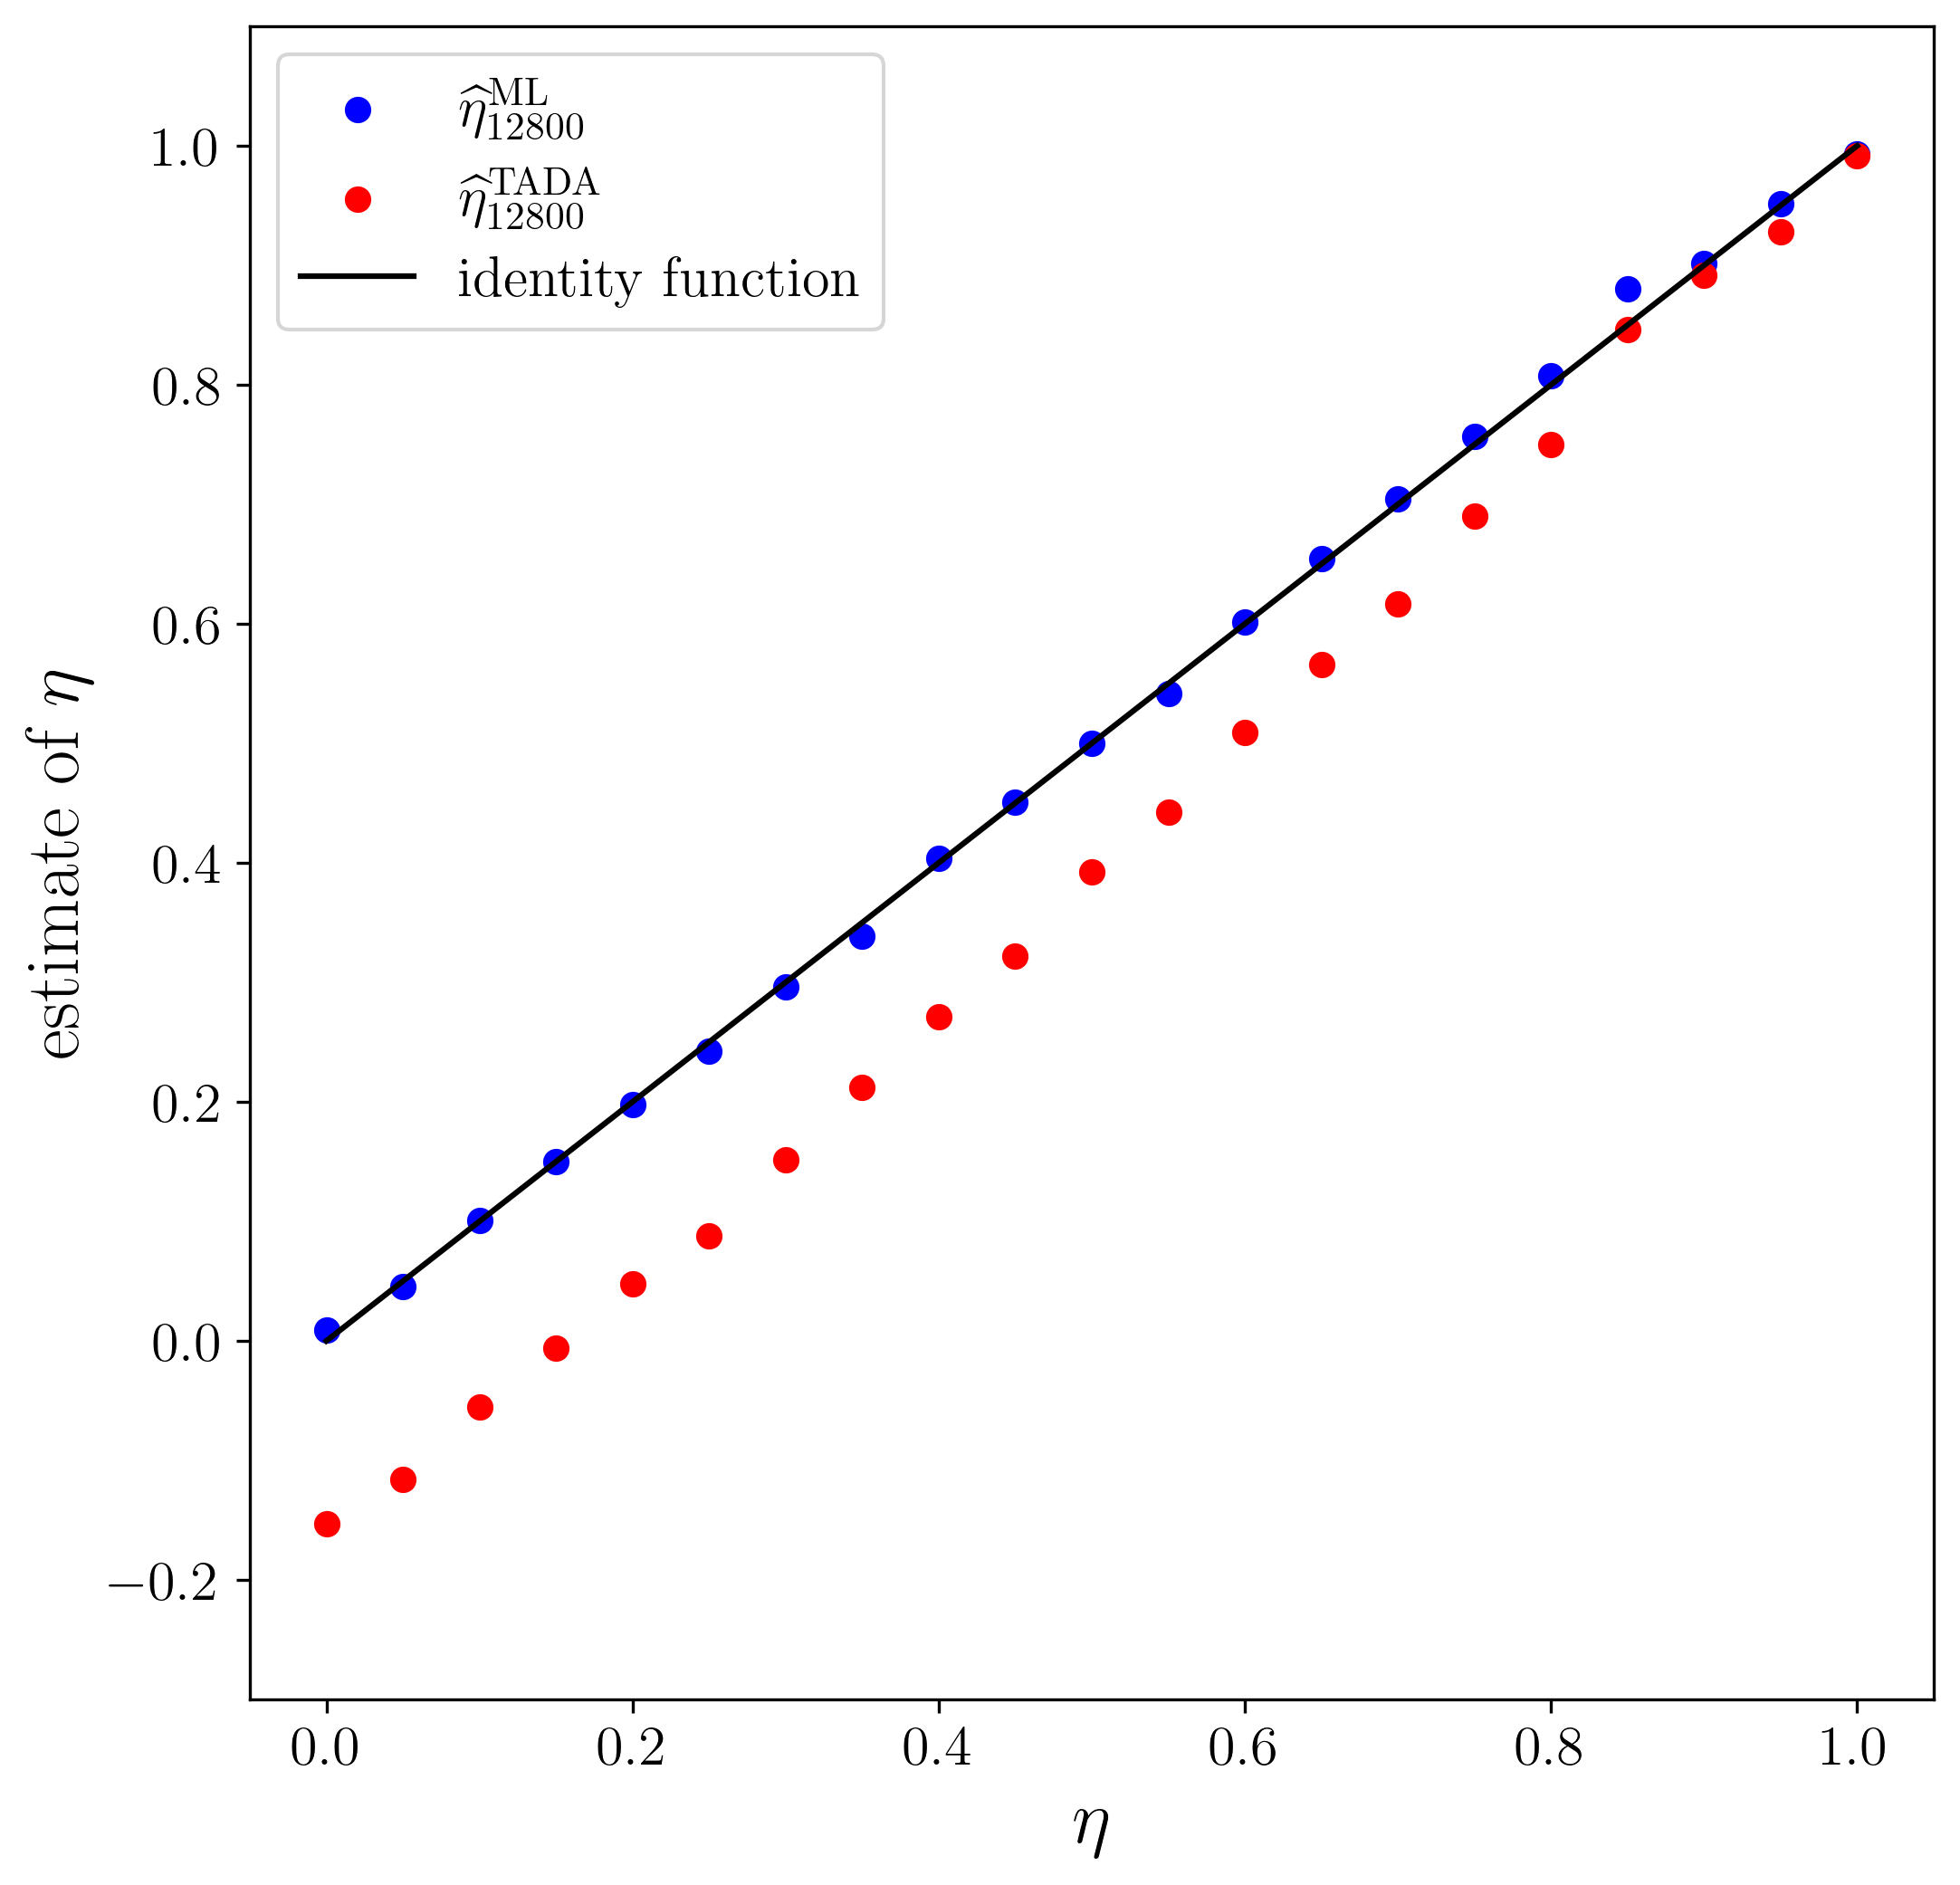

In [11]:
num_data_idx = -2
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax.scatter(
    paras_true_arr[num_data_idx, :, 0],
    paras_mle_arr[num_data_idx, :, 0],
    label=rf"$\widehat{{\eta}}_{{{num_data_list[num_data_idx]}}}^{{\text{{ML}}}}$",
    color="blue",
)
ax.scatter(
    paras_true_arr[num_data_idx, :, 0],
    paras_tada_arr[num_data_idx, :, 0],
    label=rf"$\widehat{{\eta}}_{{{num_data_list[num_data_idx]}}}^{{\text{{TADA}}}}$",
    color="red",
)
ax.plot(
    np.linspace(0, 1, 100), np.linspace(0, 1, 100), c="k", label="identity function"
)
ax.legend(fontsize=15)
ax.set_xlabel(r"$\eta$", fontsize=20)
ax.set_ylabel(r"estimate of $\eta$", fontsize=20)
ax.tick_params(axis="both", labelsize=15)

ax.set_xlim((-0.05, 1.05))
ax.set_ylim((-0.3, 1.1))

plt.savefig(f"param_recovery_{num_data_list[num_data_idx]}.png", bbox_inches="tight")


plt.show()